In [1]:
# For interactive plots, comment the next line
%pylab inline
# For interactive plots, uncomment the next line
# %pylab ipympl
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


# Introduction
For instruction on using Jupter notebooks, see the [README.MD](../../README.MD) file. 

This notebook demonstrates how to retrieve SMAP data from OpenDAP. Specifically, we will:
* Retrieve data for a specified date and region
* Retrieve data for specified points over a date range
* Retrieve data for a region using the `native_coordinates` of the data

# How to retrieve SMAP data via OpenDAP using PODPAC
* Make sure you have PODPAC properly installed WITH the **datatype** optional dependencies: `pip install podpac[datatype]`

# Setup

In [2]:
import podpac

## Provide Earth Data Login Credentials
If you do not have an earth data login, or have not activated OpenDAP access, follow the [instructions here](https://creare-com.github.io/podpac-docs/user/earthdata.html).

In [3]:
import getpass
username = password = None
username = input("Username:");   password = getpass.getpass('Password:')

Username: mpuecker
Password: ··················


## Create the PODPAC SMAP Node

In [4]:
# Create the SMAP node
product = 'SPL4SMAU'   # Level 4 soil moisture analysis update
sm = podpac.datalib.SMAP(product=product, interpolation='nearest', username=username, password=password)

##  Retrieve and plot SMAP data for a particular date over lat-lon range
Note, this example:
* Does not use locally-stored data
* Automatically does nearest-neighbor interpolation to the user's specified grid
* Does not download the whole file, only the data it needs
* Accesses a single SMAP file

(-181.0, 181.0, -91.0, 91.0)

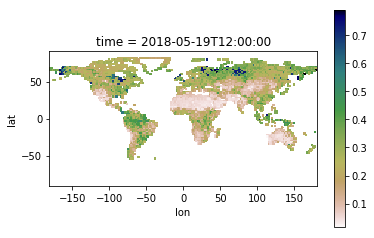

In [5]:
# dim = (start, stop, step)
lat =   (   90,  -90,-2.0)
lon =   ( -180,  180, 2.0)
# dim = value
time = '2018-05-19T12:00:00'

# Create the PODPAC Coordinates
c_world = podpac.Coordinates([podpac.crange(*lat),
                              podpac.crange(*lon),
                              time], dims=['lat', 'lon', 'time'])

# Evaluate the node to retrieve and interpolate the data
o = sm.eval(c_world)

# Plot the result
figure()
o.plot(cmap='gist_earth_r')
axis('scaled')

## Retrieve and plot SMAP data for a date range with user-specified lat-lon points
Note, this example:
* Does not use locally-stored data
* Automatically does nearest-neighbor interpolation to the user's specified grid
* Does not download the whole file, only the data it needs (in this case 4 points from multiple files)
* Accesses multiple SMAP files

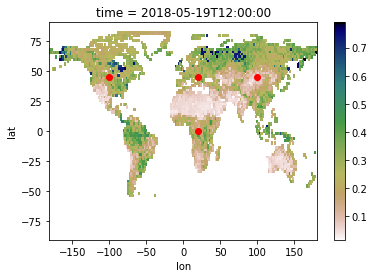

In [6]:
# Look at a list of points
lat_lon_pts = [
    (  45.0, 45.0,  0.0, 45.0),  # Lat
    (-100.0, 20.0, 20.0, 100.0), # Lon
]

# Turn the list into a numpy array
lat_lon_pts = np.array(lat_lon_pts)

# Let's plot the points
figure()
o.plot(cmap='gist_earth_r')
plot(lat_lon_pts[1], lat_lon_pts[0], 'ro')

In [7]:
# Create the PODPAC coordinates
c_pts = podpac.Coordinates([lat_lon_pts,
                            podpac.crange('2018-05-15T00', '2018-05-19T00', '3,h')], 
                            dims=['lat_lon', 'time']
                            )
# To improve the speed of data retrieval, make 6 requests in parallel
sm.threaded = True; sm.n_threads = 6

# Evaluate the node to retrieve and interpolate the data
ot = sm.eval(c_pts)

# Turn of parallel retrieval of data
sm.threaded = False

([<matplotlib.axis.XTick at 0x1eca505eb38>,
 <a list of 5 Text xticklabel objects>)

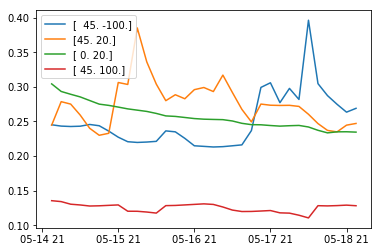

In [8]:
# Plot the results
figure()
plot(ot.time, ot.data.T)
legend([str(llp) for llp in lat_lon_pts.T])
locs, labels = xticks()
xticks(locs[::2])

## Retrieve and plot SMAP data for a particular date over lat-lon range with underlying, native SMAP coordinates
Note, this example:
* Does not use locally-stored data
* Automatically does nearest-neighbor interpolation to the user's specified grid
* Does not download the whole file, only the data it needs
* Accesses a single SMAP file

In [9]:
# Create PODPAC Coordinates for the bounding box
bbox = podpac.Coordinates([              # (start, stop, number)
                           podpac.clinspace(   49,   25, 2),  # lat
                           podpac.clinspace( -126,  -66, 2),  # lon
                          ], dims=['lat', 'lon']
)

### Get native coordinates of the SMAP data

In [10]:
# This next line computes the combined coordinates of the SMAP dataset
sm_nc = sm.find_coordinates()[0]  # find_coordinates always returns a list, but this only has one entry
sm_nc

Coordinates
	time: ArrayCoordinates1d(time): Bounds[2015-03-31T03:00:00, 2018-11-13T00:00:00], N[10584], ctype['midpoint']
	lat: ArrayCoordinates1d(lat): Bounds[-84.65644073486328, 84.65644073486328], N[1624], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-179.95474243164062, 179.95474243164062], N[3856], ctype['midpoint']

In [11]:
# Get the SMAP native coordinates in the desired bounding box
c_intersect = sm_nc.intersect(bbox)
# Drop the 'time' dimension since we are not interested in all times
c_intersect = c_intersect.drop('time')
c_intersect

Coordinates
	lat: ArrayCoordinates1d(lat): Bounds[25.02339744567871, 48.95127868652344], N[271], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-125.98908996582031, -66.05409240722656], N[643], ctype['midpoint']

### Select a specific date and time

In [12]:
# Create the PODPAC Coordinates of interest
c = podpac.coordinates.merge_dims([podpac.Coordinates.grid(time='2017-04-30T21:00:00'), c_intersect])
c

Coordinates
	time: ArrayCoordinates1d(time): Bounds[2017-04-30T21:00:00, 2017-04-30T21:00:00], N[1], ctype['midpoint']
	lat: ArrayCoordinates1d(lat): Bounds[25.02339744567871, 48.95127868652344], N[271], ctype['midpoint']
	lon: ArrayCoordinates1d(lon): Bounds[-125.98908996582031, -66.05409240722656], N[643], ctype['midpoint']

### Retrieve and plot the data

(-126.03593826293945,
 -66.00781631469727,
 24.984514236450195,
 49.00458335876465)

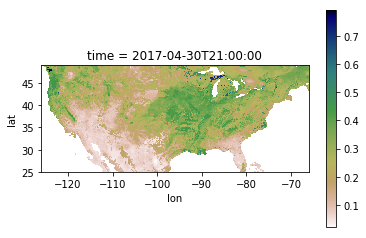

In [13]:
o = sm.eval(c)
figure()
o.plot(cmap='gist_earth_r')
axis('scaled')